<a href="https://www.kaggle.com/code/gerardomacias/alzheimer-project-tensorflow?scriptVersionId=208095762" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# importemos primero algunas bibliotecas que nos vayan a ser de utilididad.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cv2
from PIL import Image
import io
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

print(tf.__version__)

2.16.1


tanto train como test vienen en archivos parquet, asi que usamos **pd.read_parquet**

# Lo siguiente es hacer un extraccion y transformacion de nuestros archivos parquet

In [2]:
train = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
test = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'
categorias = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
data_train = pd.read_parquet(train)
data_test = pd.read_parquet(test)
data_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


tenemos que hacer algunas transformaciones para poder trabajar con las imagenes

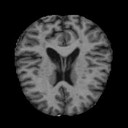

In [3]:
img_dict = data_train['image'][0]
byte_string = img_dict['bytes']
nparr = np.frombuffer(byte_string, np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

image = Image.open(io.BytesIO(byte_string))
display(image)

In [4]:
def extraccion_y_transformacion(images_set):
    et_list_images = []
    images_bytes = images_set['image']
    for img_dict in images_bytes:
        byte_string = img_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        et_list_images.append(img)
    return et_list_images

def visualizar_imagenes(image_set, categorias, limit=5):
    fig, axes = plt.subplots(1, limit, figsize=(10, 5))
    image_bytes = image_set['image']

    for i, (ax, row) in enumerate(zip(axes, image_set.iterrows())):
        img_dict = row[1]['image']
        label = row[1]['label']
        name = categorias[label]
        
        byte_string = img_dict['bytes']
        image = Image.open(io.BytesIO(byte_string))
        
        ax.imshow(image, cmap='gray')
        ax.set_title(name) 
        ax.axis('off')
        
        if i + 1 == limit:
            break

    plt.tight_layout()
    plt.show()

In [5]:
train_transformado = extraccion_y_transformacion(data_train)
test_transformado = extraccion_y_transformacion(data_test)
print(train_transformado[:1])

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]


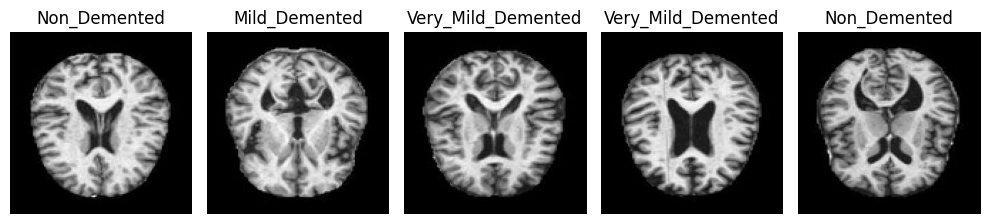

In [6]:
visualizar_imagenes(data_train, categorias, limit=5)

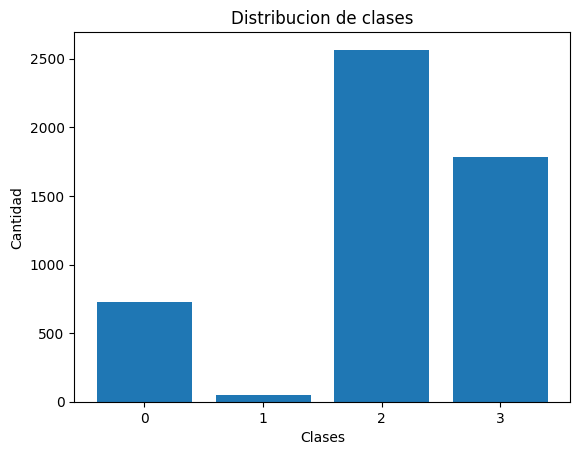

In [7]:
y_test = []
for label in data_test['label']:
    y_test.append(label)

y_train = []
for label in data_train['label']:
    y_train.append(label)
    
y_train = np.array(y_train)
y_test = np.array(y_test)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.title('Distribucion de clases')
plt.xticks(unique) 
plt.show()

## hacemos un one_hot encodign para la variable label
por ejemplo, si tenemos label = 2, se tendria que ver así [0,0,1,0]

In [8]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=4)
y_test = tf.one_hot(y_test.astype(np.int32), depth=4)
y_train

<tf.Tensor: shape=(5120, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

# vamos a estandarizar y normalizar nuestros datos

## normalizacion

In [9]:
train_transformado = np.array(train_transformado)/255
test_transformado = np.array(test_transformado)/255

## estandarizacion

In [10]:
train_transformado = [np.expand_dims(img, axis=-1) for img in train_transformado] # agregar el canal de escala de grises
test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
#test_transformado = [np.expand_dims(img, axis=-1) for img in test_transformado]
train_transformado = np.array(train_transformado)
test_transformado = np.array(test_transformado)
train_transformado[0].shape

(128, 128, 1)

In [11]:
train_transformado.shape

(5120, 128, 128, 1)

In [12]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

scaler = MinMaxScaler3D()
train_scaled = [scaler.fit_transform(X=img) for img in train_transformado]
train_scaled = np.array(train_scaled)
test_scaled = [scaler.fit_transform(X=img) for img in test_transformado]
test_scaled = np.array(test_scaled)

In [13]:
train_scaled.shape

(5120, 128, 128, 1)

# hagamos el modelo con keras

In [14]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential, initializers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [15]:
#optimizer = Adam()
optimizer = Adam(
    learning_rate=0.001,  # Tasa de aprendizaje
    beta_1=0.9,          # Decay rate del primer momento
    beta_2=0.999,        # Decay rate del segundo momento
    epsilon=1e-07        # Término de suavizado
)

model = Sequential([
    layers.Input(shape=(128,128,1)),
    
    layers.Conv2D(64, kernel_size=(2,2), activation='relu',kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Conv2D(64,kernel_size=(2,2), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer = initializers.HeNormal(seed=42), padding='same'),
    #layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(categorias), activation='softmax')
])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

## Toca entrenar el modelo

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()
history = model.fit(
    train_scaled, 
    y_train,
    batch_size=10,
    epochs=20,
    validation_split=0.1,
    callbacks=[callbacks]
)

Epoch 1/20


I0000 00:00:1731913193.874006      81 service.cc:145] XLA service 0x7fe0f8008e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731913193.874057      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731913193.874061      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 21/461 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4379 - loss: 6.9551

I0000 00:00:1731913198.391375      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


461/461 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4926 - loss: 1.6963 - val_accuracy: 0.5586 - val_loss: 0.9108
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5774 - loss: 0.8919 - val_accuracy: 0.6328 - val_loss: 0.8245
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6340 - loss: 0.8162 - val_accuracy: 0.6914 - val_loss: 0.6962
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7229 - loss: 0.6464 - val_accuracy: 0.7910 - val_loss: 0.5415
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7759 - loss: 0.5156 - val_accuracy: 0.7852 - val_loss: 0.5262
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8606 - loss: 0.3456 - val_accuracy: 0.8867 - val_loss: 0.3253
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9128 - loss: 0.2390 - val_accuracy: 0.8789 - val_loss: 0.2985
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9256 - loss: 0.1858 - val_accuracy: 0.9219 - va

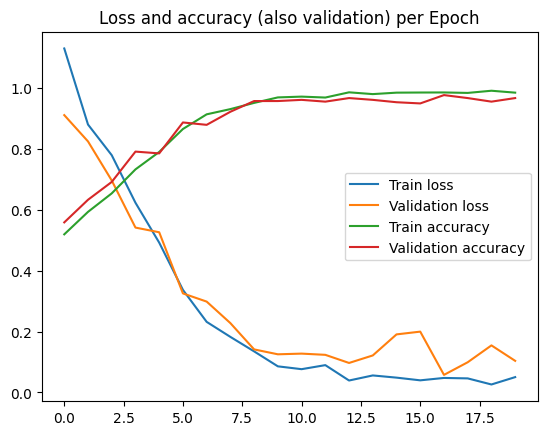

In [17]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Loss and accuracy (also validation) per Epoch')
plt.show()

In [18]:
history.model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>]

In [19]:
w, b = history.model.layers[0].get_weights()

In [20]:
b.shape

(64,)

# evaluemos la exactitud del modelo

In [21]:
test_loss, test_acc = model.evaluate(test_scaled, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

40/40 - 1s - 27ms/step - accuracy: 0.9617 - loss: 0.1478
Test accuracy: 0.961718738079071


In [22]:
predictions = model.predict(test_scaled)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
predictions[0]

array([3.2196983e-04, 3.5878713e-08, 4.9006473e-02, 9.5067155e-01],
      dtype=float32)

tenemos que la prediccion es un arreglo de 4 números. Estos números representan el nivel de confianza del modelo sobre cada una de las imagenes de las 4 clases que hay. Ahora veamos como se obtiene el nivel de confianza más alto

In [24]:
np.argmax(predictions[0])

3

el modelo tiene más confinza en que la primera imagen pertenece a la clase 3, o bien que la radiografia pertenece a **Very_Mild_Demented**

In [25]:
data_test['label'][0]

3

y vemos que en efecto ha acertado

In [26]:
from sklearn.metrics import classification_report
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       172
           1       1.00      0.93      0.97        15
           2       0.98      0.96      0.97       634
           3       0.93      0.99      0.96       459

    accuracy                           0.96      1280
   macro avg       0.98      0.94      0.96      1280
weighted avg       0.96      0.96      0.96      1280



# graficos

In [27]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categorias[predicted_label],
                                100*np.max(predictions_array),
                                categorias[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

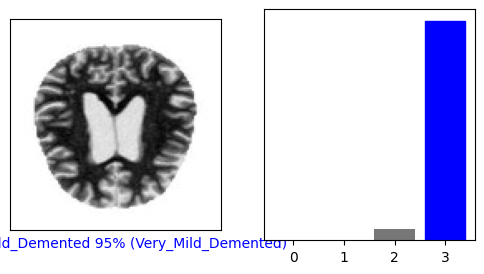

In [28]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

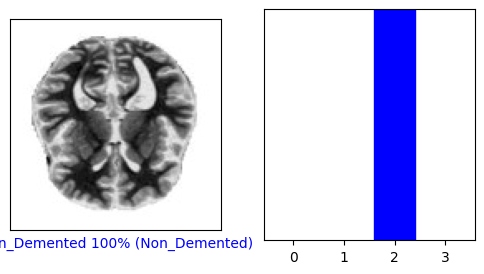

In [29]:
i = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.show()

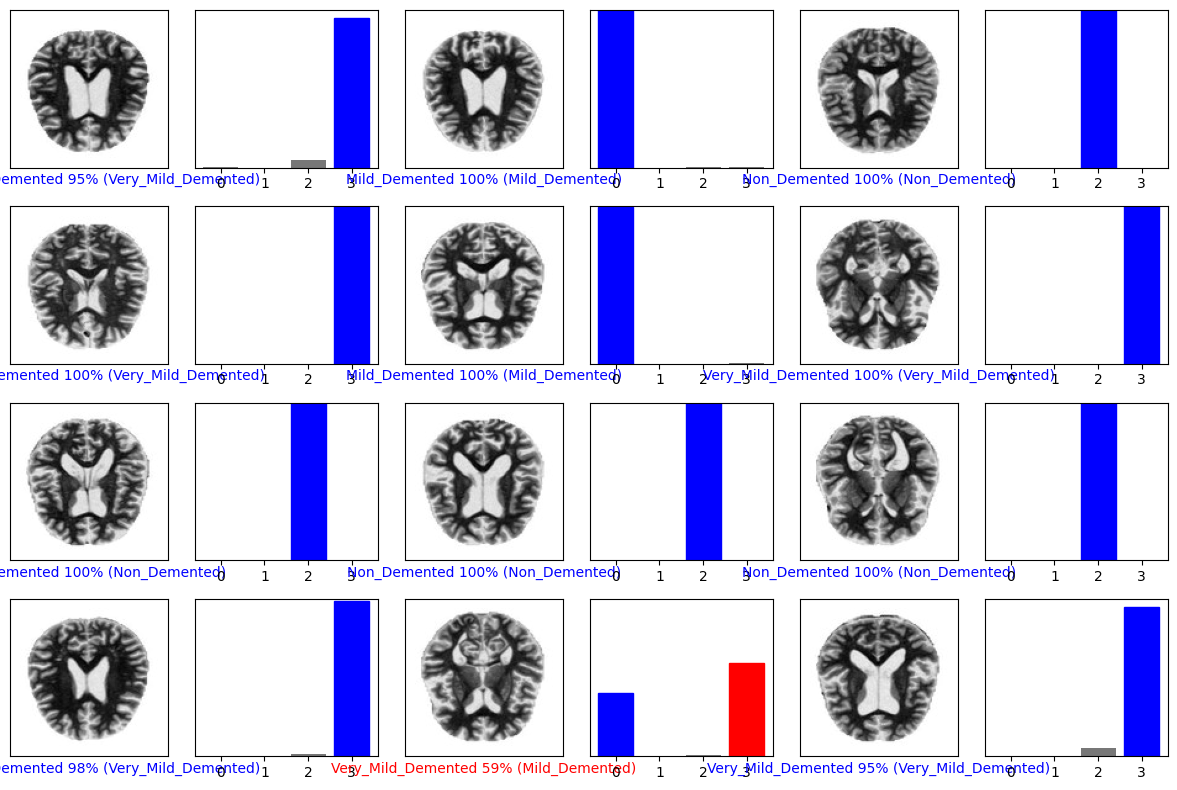

In [30]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], np.argmax(y_test, axis=1), test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], np.argmax(y_test, axis=1))
plt.tight_layout()
plt.show()